## tensor
tensor是pytorch中最基本的部分，因为要计算模型训练和推理的时间，就要计算单位加法和乘法的次数，而这个次数是由tensor和数据类型决定的，因为tensor存储parameters, gradients, optimizer state, data, activations.

In [1]:
# 创建tensor的几种方法
import torch
x = torch.tensor([[1., 2, 3], [4, 5, 6]])  # @inspect x
x = torch.zeros(4, 8)  # 4x8 matrix of all zeros @inspect x
x = torch.ones(4, 8)  # 4x8 matrix of all ones @inspect x
x = torch.randn(4, 8)  # 4x8 matrix of iid Normal(0, 1) samples @inspect x

#### 浮点数的类型
##### float 32
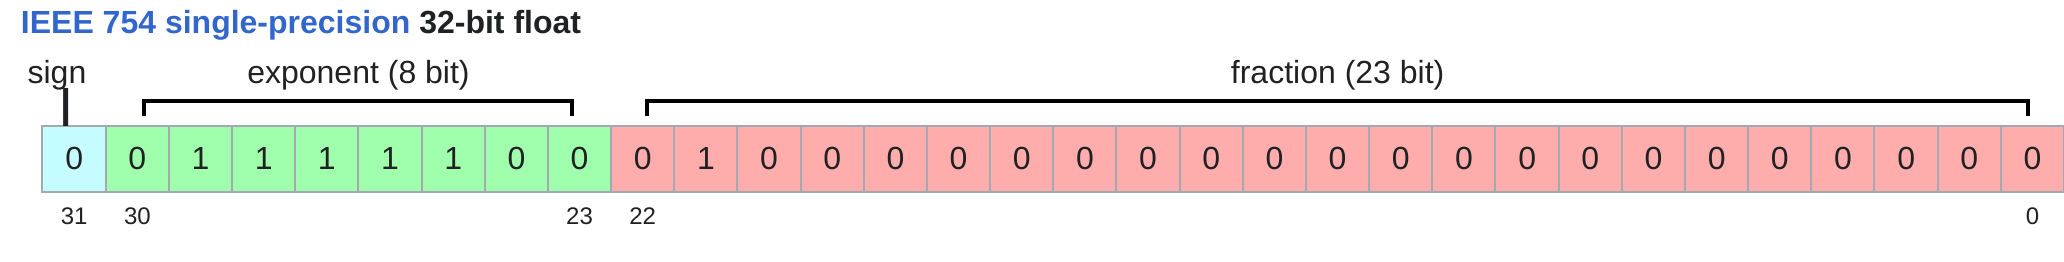
f32是默认的数据类型，精度比较高，占内存4byte

##### float16
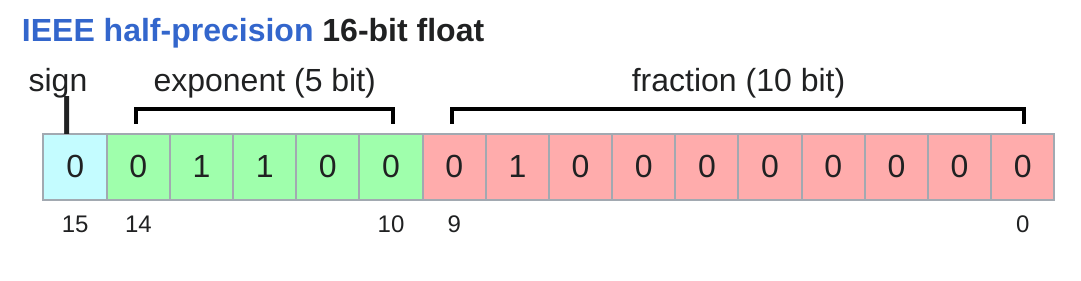
f16占内存2byte,会出现underflow的问题（非常小的数会被认定为0）

##### bfloat16
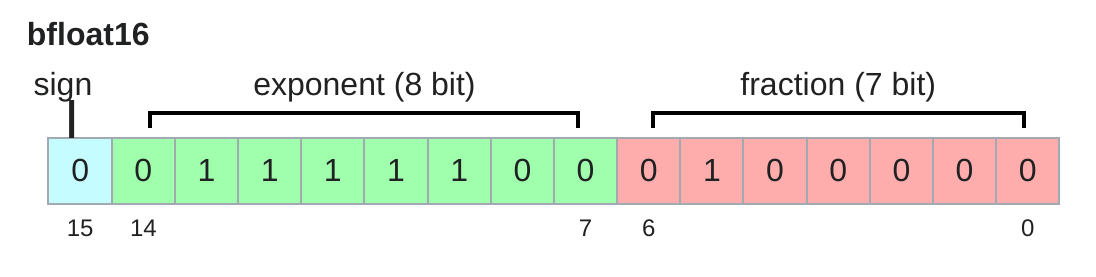
与f16占内存一样大，都是2个byte，但是与f32能够表示的数值范围一样，不过精度没有f32高

##### fp8
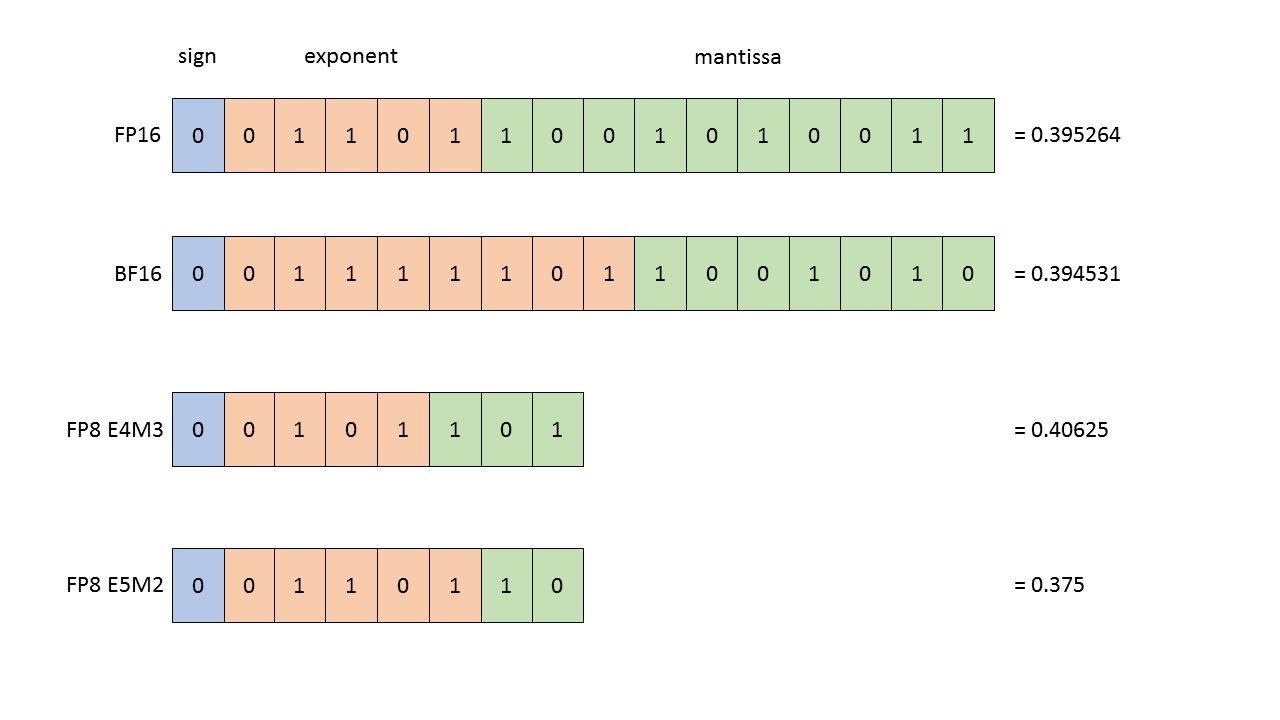


#### 使用浮点数的不同情况
 - 如果需要继续计算，那么精度会积累，此时就要用f32
 - 如果这个模型已经训练好了，要用于infer,那么此时可以把它变成bf16

  Choice of data type (float32, bfloat16, fp8) have tradeoffs.
    
Higher precision: more accurate/stable, more memory, more compute
    
Lower precision: less accurate/stable, less memory, less compute
    How can we get the best of both worlds?
**Solution: use float32 by default, but use {bfloat16, fp8} when possible.**

A concrete plan:
    
 - Use {bfloat16, fp8} for the forward pass (activations). 
 - Use float32 for the rest (parameters, gradients).
    
**Mixed precision training**
 [Micikevicius+ 2017]

### tensor在内存中的位置
 - default:在CPU上
 - 若是考虑massive parallelism of GPUs，那么就可以把它搬运到GPU上
```
x = torch.zeros(2,2)
y = x.to("cuda:0")
```
 - 当然也可以在初始化的时候就放在GPU上
`z = torch.zeros(32, 32, device="cuda:0")`

### tensor的存储
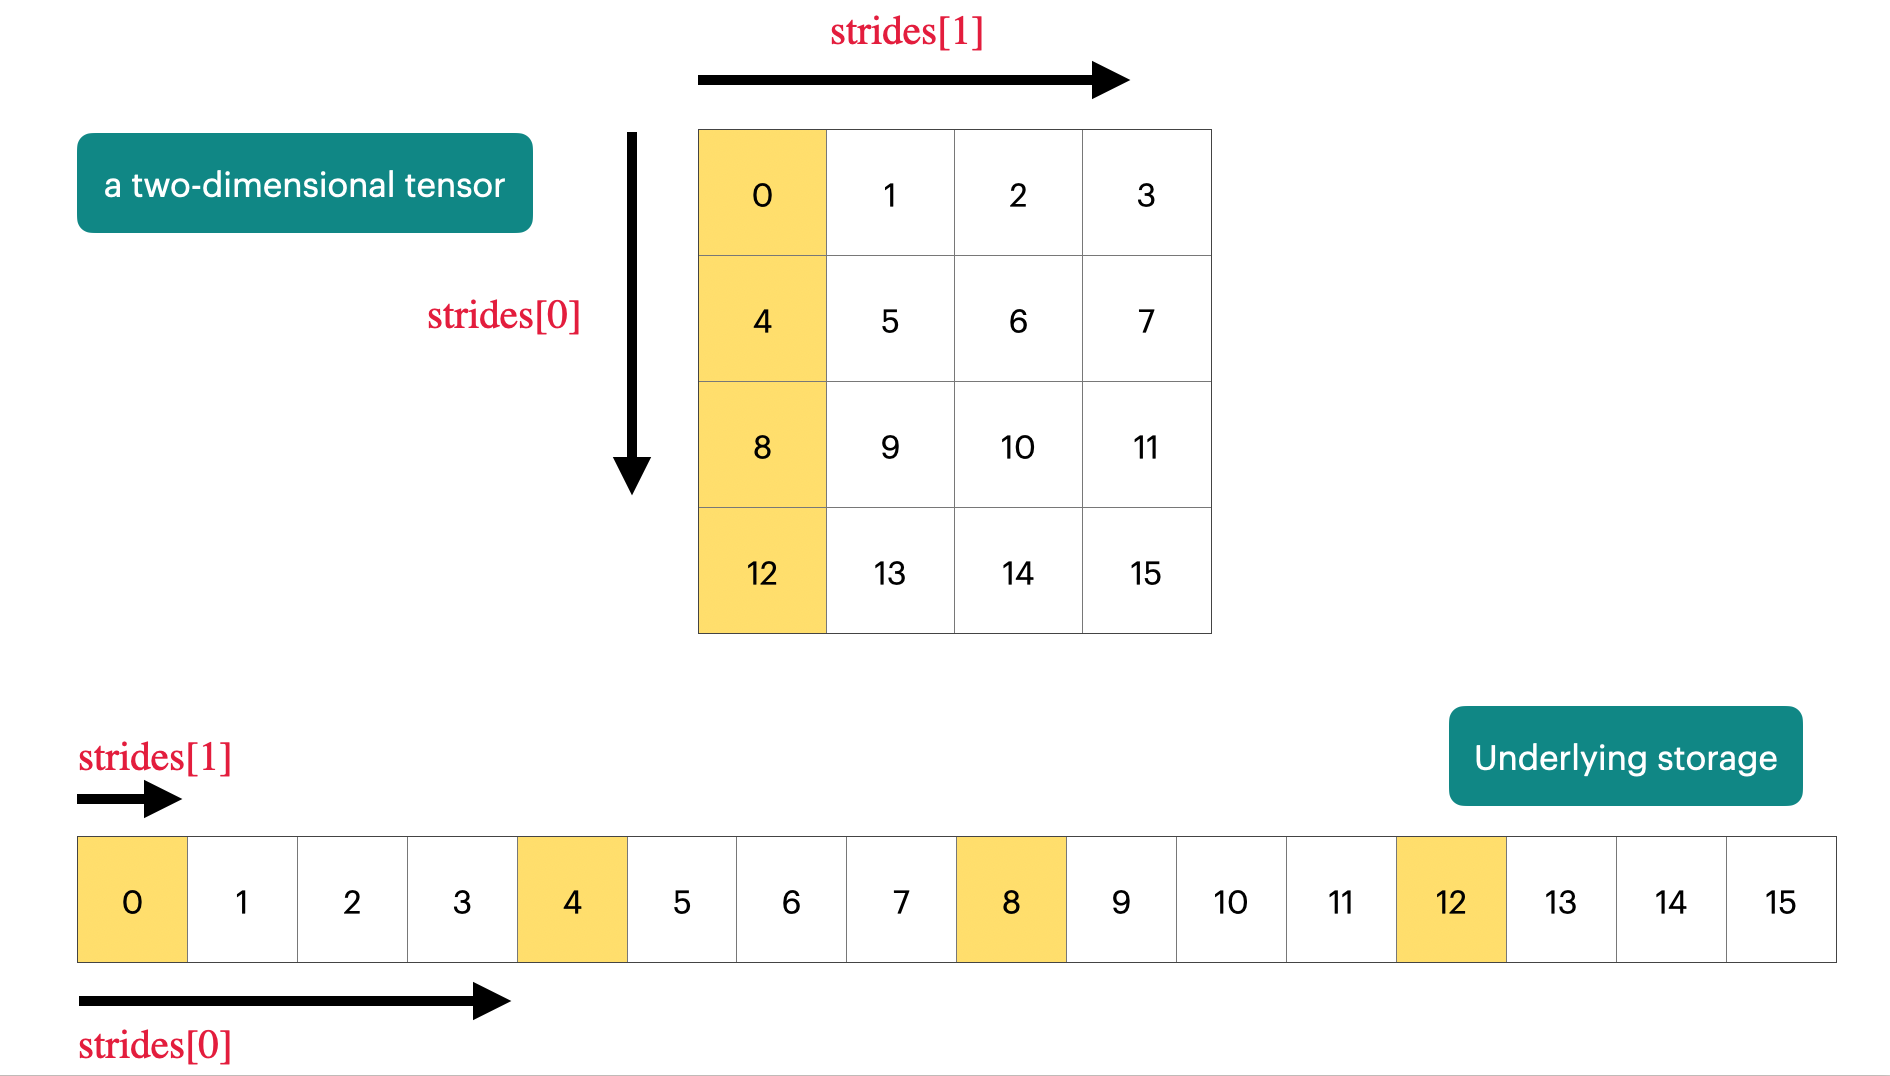
 - 虽然是矩阵，但是在内存中其实就是一个一维数组（记录数据）和元数据（头节点和每一个维度的stride）
     - To go to the next row (dim 0), skip 4 elements in storage.
        `assert x.stride(0) == 4`
     - To go to the next column (dim 1), skip 1 element in storage.
        `assert x.stride(1) == 1`
     - To find an element:
        ```
        r, c = 1, 2
        index = r * x.stride(0) + c * x.stride(1)  # @inspect index
        assert index == 6
        ```

### tensor的操作
*许多tensor的操作其实并没有在内存中新复制一个tensor*，比如`view`,`transpose`等
*还有一些是必须新建复制一个的*
```python
x = torch.tensor([1, 4, 9])
assert torch.equal(x.pow(2), torch.tensor([1, 16, 81]))
assert torch.equal(x.sqrt(), torch.tensor([1, 2, 3]))
assert torch.equal(x.rsqrt(), torch.tensor([1, 1 / 2, 1 / 3]))  # i -> 1/sqrt(x_i)
assert torch.equal(x + x, torch.tensor([2, 8, 18]))
assert torch.equal(x * 2, torch.tensor([2, 8, 18]))
assert torch.equal(x / 0.5, torch.tensor([2, 8, 18]))
```

### tensor的计算
加法和乘法可以使用einops库,还有reduce和rearrange

In [2]:
import torch

# 直接使用 `torch.Tensor` 进行类型注解
x: torch.Tensor = torch.ones(2, 3, 4)  # 形状: (batch, seq1, hidden)
y: torch.Tensor = torch.ones(2, 3, 4)  # 形状: (batch, seq2, hidden)

# 传统方式：矩阵乘法
z = x @ y.transpose(-2, -1)  # batch, sequence, sequence

# 新方式：使用 einsum 进行操作
from einops import einsum
z_einsum = einsum(x, y, "batch seq1 hidden, batch seq2 hidden -> batch seq1 seq2")

# 打印结果
print(f"Traditional z: {z.shape}")
print(f"Einops z_einsum: {z_einsum.shape}")


Traditional z: torch.Size([2, 3, 3])
Einops z_einsum: torch.Size([2, 3, 3])


In [3]:
import torch
from einops import reduce

# Define a tensor of shape (batch, seq, hidden)
x = torch.ones(2, 3, 4)  # Shape: (2, 3, 4)

# Old way to reduce tensor (e.g., mean along last dimension):
y = x.mean(dim=-1)  # Shape: (2, 3), reduced along the last dimension

# New (einops) way to reduce tensor (e.g., sum along the last dimension):
y = reduce(x, "... hidden -> ...", "sum")  # Shape: (2, 3), sum along the last dimension
y

tensor([[4., 4., 4.],
        [4., 4., 4.]])

In [4]:
import torch
from einops import rearrange, einsum

# Define a tensor of shape (batch, seq, total_hidden)
x = torch.ones(2, 3, 8)  # Shape: (2, 3, 8), where total_hidden = heads * hidden1


# Rearrange the total_hidden dimension into two dimensions (heads, hidden1)
x = rearrange(x, "... (heads hidden1) -> ... heads hidden1", heads=2)
# After this, x shape becomes (2, 3, 2, 4), where heads=2 and hidden1=4
print(x.size())

torch.Size([2, 3, 2, 4])


In [5]:
# Combine the heads and hidden2 dimensions back together
x = rearrange(x, "... heads hidden2 -> ... (heads hidden2)")
# After this, x shape becomes (2, 3, 8), heads and hidden2 are combined
print(x.size())

torch.Size([2, 3, 8])


#### 浮点运算（FLOP）是像加法（x + y）或乘法（x * y）这样的基本操作。
 - FLOPs：浮点运算（表示已完成的计算量）
 - FLOP/s：每秒浮点运算次数（也写作 FLOPS），用于衡量硬件的速度。
     - A100 has a peak performance of 312 teraFLOP/s 
        `assert a100_flop_per_sec == 312e12`
     - H100 has a peak performance of 1979 teraFLOP/s with sparsity, 50% without
       `assert h100_flop_per_sec == 1979e12 / 2`
     - 8 H100s for 2 weeks:
        `total_flops = 8 * (60 * 60 * 24 * 7) * h100_flop_per_sec  # @inspect total_flops`

In [6]:
# 计算一个矩阵乘法所需要的FLOPS数量
B = 1024  # Number of points
D = 256  # Dimension
K = 64  # Number of outputs
x = torch.ones(B, D)
w = torch.randn(D, K)
y = x @ w
#We have one multiplication (x[i][j] * w[j][k]) and one addition per (i, j, k) triple.
actual_num_flops = 2 * B * D * K  # @inspect actual_num_flops
actual_num_flops

33554432

### FLOPs 计算公式
对于前向传播操作（例如，Transformer 模型），FLOPs 计算可以通过以下公式进行估算：
 - B 是数据点的数量
 - (D, K) 是模型的参数数量

一般情况下，前向传播的 FLOPs 大致为：

$FLOPs=2×(tokens数)×(参数数)$

这个公式在 Transformer 模型中是一个近似的一阶公式。

### FLOPs 转换为墙钟时间
计算 FLOPs 是理论上的计算量，但我们更关心实际的运行时间。
可以通过以下代码来测量：
```python
actual_time = time_matmul(x, w)  # 计算矩阵乘法的实际时间
actual_flop_per_sec = actual_num_flops / actual_time  # 计算每秒的 FLOPs
```
每个 GPU 都有一个规格表，报告其 峰值性能，也就是其最大能处理的 FLOP/s。

**f/s 会受到数据类型的影响，例如，使用 float16 数据类型时，GPU 可以处理更多的 FLOPs，而 float32 则会比较慢,此外，f/s还与device有关**
```python
promised_flop_per_sec = get_promised_flop_per_sec(device, x.dtype)  # @inspect promised_fl
```




### MFU
模型浮点运算利用率（MFU）是通过实际的浮点运算每秒（actual FLOP/s）与理论上的峰值浮点运算每秒（promised FLOP/s）的比值来衡量的。

MFU 计算公式：
$$
mfu= \frac{promised\_FLOP/s}{actual\_FLOP/s}
$$
 
如果 MFU >= 0.5，通常认为性能非常好，特别是当矩阵乘法占主导地位时，MFU 会更高。
 - 与 float32 相比，使用 bfloat16 时，实际的 FLOP/s 通常会更高，因为 bfloat16 占用的内存较小，处理速度更快。
 - 如果 MFU 值较低，可能是因为 promised FLOP/s 过于乐观，或其他因素（如内存带宽、硬件限制等）导致性能未能充分发挥。

In [7]:
x = torch.tensor([1., 2, 3])
w = torch.tensor([1., 1, 1], requires_grad=True)
pred_y = x @ w
loss = 0.5 * (pred_y - 5).pow(2)
print(loss)
# 进行反向传播
loss.backward()

# 确保 w.grad 被正确计算
assert torch.equal(w.grad, torch.tensor([1, 2, 3]))

tensor(0.5000, grad_fn=<MulBackward0>)


### 计算梯度的 FLOPs（gradients_flops）

我们基于一个简单的线性模型来计算进行梯度计算时的 FLOPs。首先，定义模型并计算前向传播的 FLOPs。
给定如下模型结构：
- 输入 $x \xrightarrow{w_1} h_1 \xrightarrow{w_2} h_2 \xrightarrow{} \text{loss}$

其中：
- \(x\) 是输入，
- \(w_1\) 和 \(w_2\) 是权重矩阵，
- \(h_1\) 和 \(h_2\) 是中间激活（hidden states），
- `loss` 是损失函数，依赖于 \(h_2\)。
```python
x = torch.ones(B, D, device=device)
w1 = torch.randn(D, D, device=device, requires_grad=True)
w2 = torch.randn(D, K, device=device, requires_grad=True)
```
#### 前向传播 FLOPs

在模型中，假设我们有以下步骤：

1. **计算 x @ w1**：
   - 这是矩阵乘法操作，涉及每个元素的乘法和加法，计算量为 \(2 \times B \times D \times D\)，其中 B 是数据点数，D 是维度。
   
2. **计算 h1 @ w2**：
   - 同样是矩阵乘法，计算量为 \(2 \times B \times D \times K\)，其中 K 是输出数。

因此，前向传播的总 FLOPs 计算为：
```python
num_forward_flops = (2 * B * D * D) + (2 * B * D * K)
```

#### 反向传播计算步骤


使用链式法则，我们可以得到：
$$
\frac{\partial \text{loss}}{\partial w_2} = h_1^T \cdot \frac{\partial \text{loss}}{\partial h_2}
$$
这里，涉及的矩阵维度如下：
- \( h_1 \) 的维度为 \([B, D]\)；
- \( h_2 \) 的维度为 \([B, K]\)；
- \( w_2 \) 的维度为 \([D, K]\)。
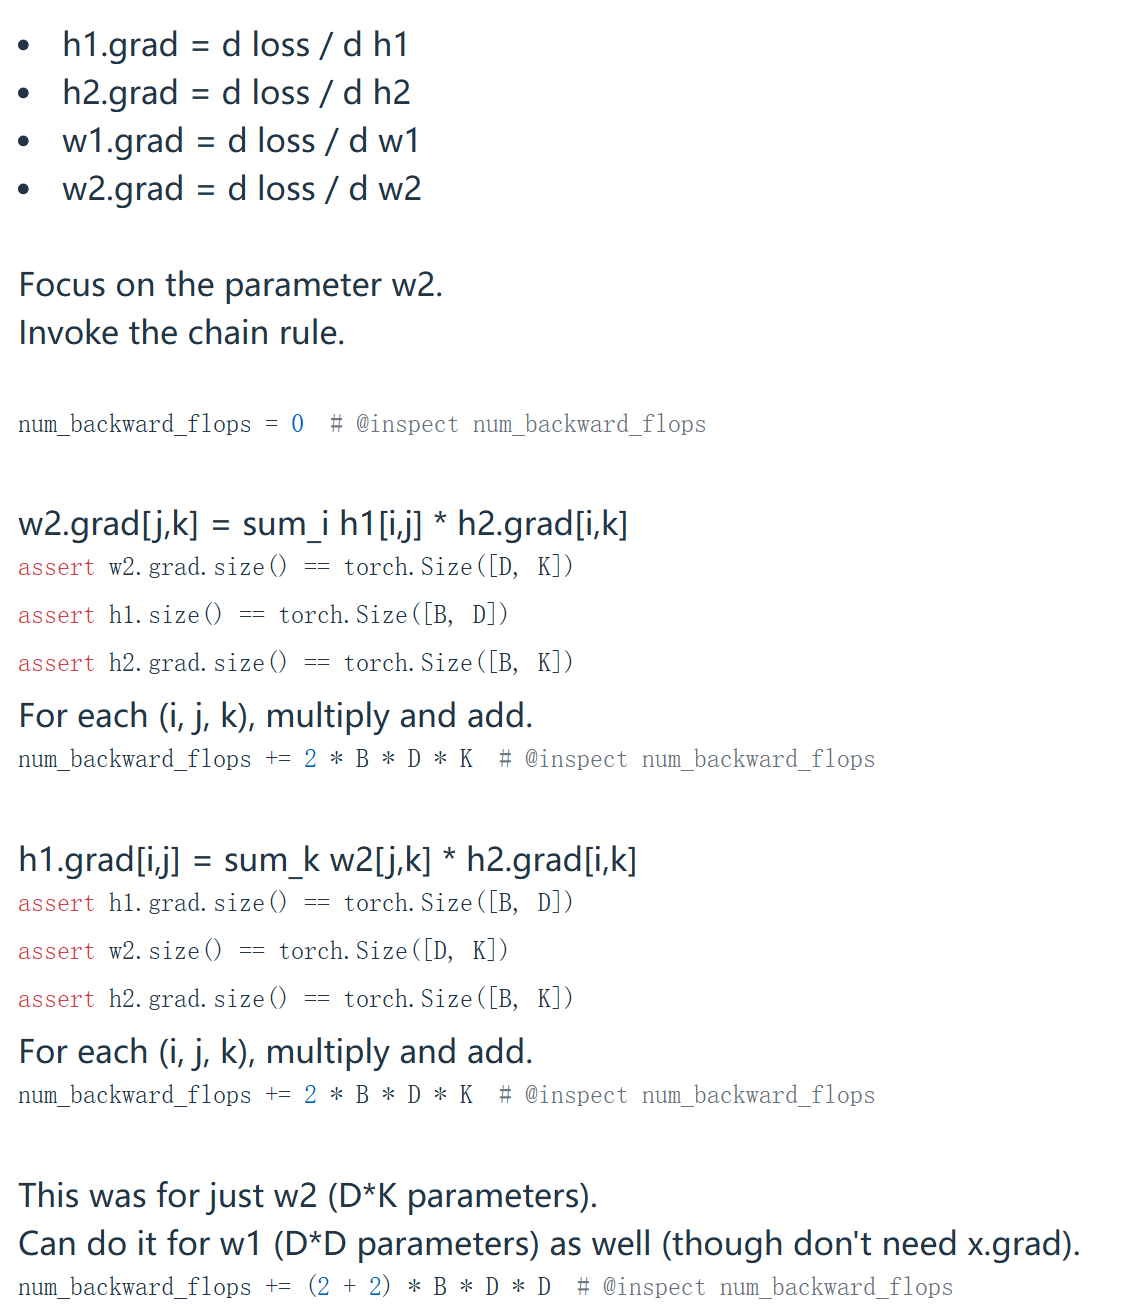

前向传播：2 次浮点运算 * 数据点（Batch） * 参数数量。

反向传播：4 次浮点运算 * 数据点 （Batch） * 参数数量。

总 FLOPs：6 次浮点运算 * 数据点（Batch）  * 参数数量。

## parameter initialization
为了防止数据爆炸
```python
w = nn.Parameter(torch.randn(input_dim, output_dim) / np.sqrt(input_dim))
output = x @ w  # @inspect output
```

In [8]:
# build a model
def custom_model():
    #Let's build up a simple deep linear model using nn.Parameter.
    D = 64  # Dimension
    num_layers = 2
    model = Cruncher(dim=D, num_layers=num_layers)
    param_sizes = [
        (name, param.numel())
        for name, param in model.state_dict().items()
    ]
    assert param_sizes == [
        ("layers.0.weight", D * D),
        ("layers.1.weight", D * D),
        ("final.weight", D),
    ]
    num_parameters = get_num_parameters(model)
    assert num_parameters == (D * D) + (D * D) + D
    #Remember to move the model to the GPU.
    device = get_device()
    model = model.to(device)
    #Run the model on some data.
    B = 8  # Batch size
    x = torch.randn(B, D, device=device)
    y = model(x)
    assert y.size() == torch.Size([B])

In [9]:
import torch.nn as nn
class Linear(nn.Module):
    """Simple linear layer."""
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, output_dim) / np.sqrt(input_dim))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight

In [10]:
class Cruncher(nn.Module):
    def __init__(self, dim: int, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([
            Linear(dim, dim)
            for i in range(num_layers)
        ])
        self.final = Linear(dim, 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply linear layers
        B, D = x.size()
        for layer in self.layers:
            x = layer(x)
        # Apply final head
        x = self.final(x)
        assert x.size() == torch.Size([B, 1])
        # Remove the last dimension
        x = x.squeeze(-1)
        assert x.size() == torch.Size([B])
        return x

### 模型的随机性
建议使用固定的随机数种子：重现问题情景

In [11]:
# Torch
seed = 0
torch.manual_seed(seed)
# NumPy
import numpy as np
np.random.seed(seed)
# Python
import random
random.seed(seed)

### 数据加载

 - 原始数据存储
```python
orig_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=np.int32)
orig_data.tofile("data.npy")
```
将该数据存储到一个二进制文件 data.npy 中。
 - 延迟加载数据
```python
data = np.memmap("data.npy", dtype=np.int32)#这是 numpy 中的内存映射功能。它可以让你访问一个文件中的数据，但不将整个文件加载到内存中，而是仅加载你访问的部分。
```
 - **数据加载器**
```python
B = 2  # Batch size
L = 4  # Length of sequence
x = get_batch(data, batch_size=B, sequence_length=L, device=get_device())
assert x.size() == torch.Size([B, L])
```
Batch Size (B)：设置批量大小为 2，表示每次加载 2 个数据序列。
Sequence Length (L)：设置序列长度为 4，表示每个序列包含 4 个数据点

### 优化器
Let's define the AdaGrad optimizer
 - momentum = SGD + exponential averaging of grad
 - AdaGrad = SGD + averaging by grad^2
 - RMSProp = AdaGrad + exponentially averaging of grad^2   
 - Adam = RMSProp + momentum

In [12]:
from collections.abc import Iterable  # 导入 Iterable
import torch
import torch.nn as nn

# 定义 AdaGrad 优化器
class AdaGrad(torch.optim.Optimizer):
    def __init__(self, params: Iterable[nn.Parameter], lr: float = 0.01):
        super(AdaGrad, self).__init__(params, dict(lr=lr))
    def step(self):
        for group in self.param_groups:
            lr = group["lr"]
            for p in group["params"]:
                # Optimizer state
                state = self.state[p]
                grad = p.grad.data
                # Get squared gradients g2 = sum_{i<t} g_i^2
                g2 = state.get("g2", torch.zeros_like(grad))
                # Update optimizer state
                g2 += torch.square(grad)
                state["g2"] = g2
                # Update parameters
                p.data -= lr * grad / torch.sqrt(g2 + 1e-5)

In [13]:
# model memory
num_layers = 4
 # Parameters
num_parameters = (D * D * num_layers) + D  # @inspect num_parameters    assert num_parameters == get_num_parameters(model)
# Activations
num_activations = B * D * num_layers  # @inspect num_activations
#激活值（activations） 是指每一层的输出。它们是通过输入数据和网络参数进行运算得到的结果，通常是通过激活函数（例如 ReLU、Sigmoid 等）应用于加权和的结果。
# Gradients
num_gradients = num_parameters  # @inspect num_gradients
# Optimizer states
num_optimizer_states = num_parameters  # @inspect num_optimizer_states
# Putting it all together, assuming float32
total_memory = 4 * (num_parameters + num_activations + num_gradients + num_optimizer_states)  # @inspect total_memory

###  Compute (for one step)
**flops = 6 * B * num_parameters**

In [14]:
# 训练的基本流程复习
def train_loop():
    #Generate data from linear function with weights (0, 1, 2, ..., D-1).
    D = 16
    true_w = torch.arange(D, dtype=torch.float32, device=get_device())
    def get_batch(B: int) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.randn(B, D).to(get_device())
        true_y = x @ true_w
        return (x, true_y)
    #Let's do a basic run
    train("simple", get_batch, D=D, num_layers=0, B=4, num_train_steps=10, lr=0.01)
    #Do some hyperparameter tuning
    train("simple", get_batch, D=D, num_layers=0, B=4, num_train_steps=10, lr=0.1)
def train(name: str, get_batch,
          D: int, num_layers: int,
          B: int, num_train_steps: int, lr: float):
    model = Cruncher(dim=D, num_layers=0).to(get_device())
    optimizer = SGD(model.parameters(), lr=0.01)
    for t in range(num_train_steps):
        # Get data
        x, y = get_batch(B=B)
        # Forward (compute loss)
        pred_y = model(x)
        loss = F.mse_loss(pred_y, y)
        # Backward (compute gradients)
        loss.backward()
        # Update parameters
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)


### 在中断训练时需要保存模型的参数要用到checkpoint

In [15]:
def checkpointing():
    #Training language models take a long time and certainly will certainly crash.
    #You don't want to lose all your progress.
    #During training, it is useful to periodically save your model and optimizer state to disk.
    model = Cruncher(dim=64, num_layers=3).to(get_device())
    optimizer = AdaGrad(model.parameters(), lr=0.01)
    #Save the checkpoint:
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "model_checkpoint.pt")
    #Load the checkpoint:
    loaded_checkpoint = torch.load("model_checkpoint.pt")